In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyeo import classification as cls

from tpot import TPOTClassifier

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

/home/localadmin1/miniconda3/envs/eoenv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [16]:
band_labels = ["ndvi","ci","psri","gndvi","s2_rep","ireci","s2_b", "s2_g", "s2_r", "s2_nir", "hv", "vv"]

training_data = pd.read_csv("data/training_sigs_12_bands.csv", names=
                           ["class"]+band_labels).astype(np.uint16)

In [17]:
training_data

,class,ndvi,ci,psri,gndvi,s2_rep,ireci,s2_b,s2_g,s2_r,s2_nir,hv,vv
0,3,5506,8515,919,5570,715,2301,438,592,603,2081,6223,23284
1,3,4915,7483,1328,5023,722,2266,535,757,779,2285,4225,20804
2,3,3987,6554,2173,4750,726,1948,590,832,1005,2338,3983,14438
3,3,6586,13830,460,5982,722,4148,461,684,560,2721,3785,28567
4,3,6149,13607,690,5820,721,3783,463,677,611,2563,3162,25760
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238030,1,6851,16527,320,6417,718,2759,258,354,303,1622,6451,32767
238031,1,6987,15728,570,6512,725,3308,262,412,346,1951,4950,27877
238032,1,6677,14893,376,6123,726,3387,353,496,411,2063,4279,22309
238033,1,6304,13895,662,5972,726,3354,373,534,480,2118,5345,22062


In [79]:
def sample_class(class_df):
    return class_df.sample(100)
    
sample_data = training_data.groupby('class').apply(sample_class).reset_index(1)

In [80]:
sampled_data

class  ndvi     ci  psri  gndvi  s2_rep  ireci  s2_b  s2_g  \
class                                                                      
1     135942      1  7198  20218    11   6327     722   4252   334   464   
      81120       1  7222  24635   116   6564     722   5039   331   454   
      102911      1  7415  24894   245   6617     725   5534   305   480   
      211536      1  7303  23395   138   6574     722   4791   315   451   
      225803      1  6710  16224   596   6355     726   2896   269   394   
...             ...   ...    ...   ...    ...     ...    ...   ...   ...   
7     16116       7  1274   1570  4095   2969     701    507   787  1127   
      7664        7  1001    687  4756   3200     666    498   936  1364   
      1821        7  1417   1865  3434   3118     682    626   939  1217   
      179827      7  1533   2018  5070   4058     722    966   827  1330   
      1162        7  1197   1641  4996   3115     730    681   977  1551   

              s2_r  s2_nir     hv     vv  
class                                     
1     135942   336    2063   3678  24352  
      81120    353    2189  18058  32767  
      102911   350    2358   8130  32767  
      211536   340    2182   4758  26984  
      225803   348    1768   8536  32767  
...            ...     ...    ...    ...  
7     16116   1609    2079   2776  11974  
      7664    2166    2648   7340  32767  
      1821    1744    2320   4311  19504  
      179827  2310    3147    986   3684  
      1162    2323    2955   4056  18263  

[700 rows x 13 columns]

In [56]:
%matplotlib inline
sampled_data.groupby(by="class").mean().transpose().plot()

ValueError: 'class' is both an index level and a column label, which is ambiguous.

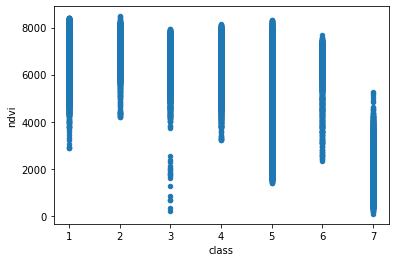

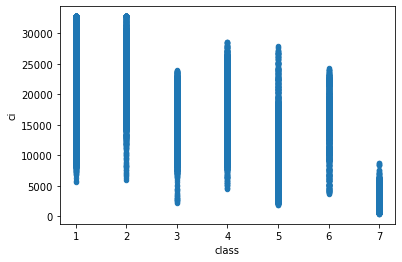

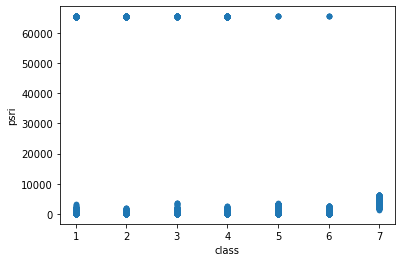

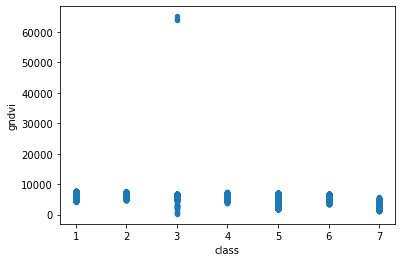

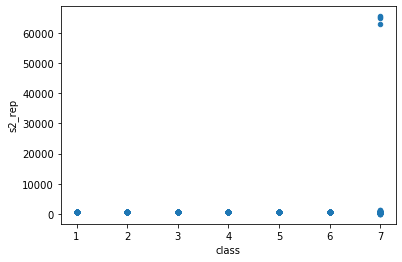

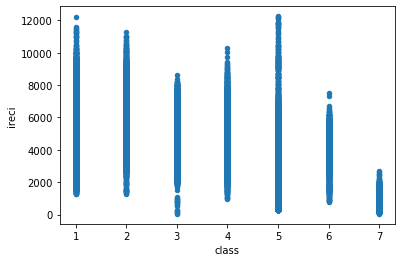

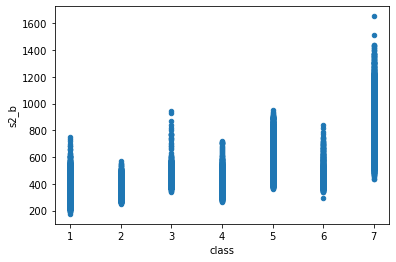

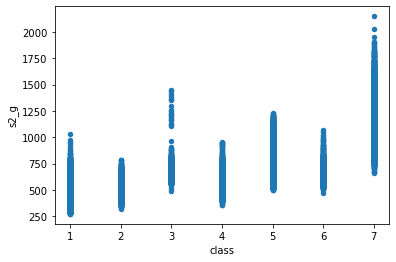

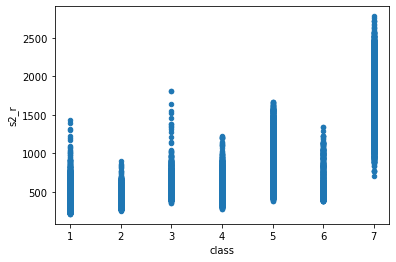

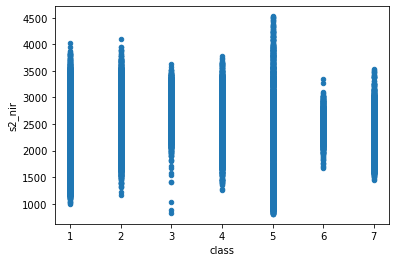

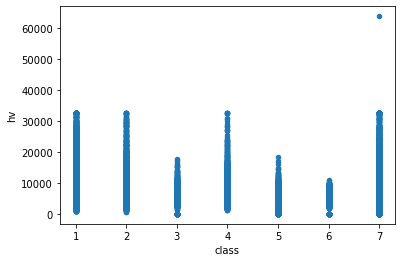

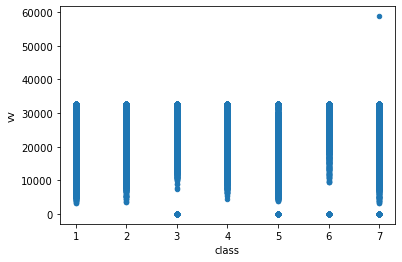

In [27]:
for i in range(0,12):
    training_data.plot.scatter(x='class', y=band_labels[i])

In [58]:
labels = sampled_data['class']
features = sampled_data.loc[:,'ndvi':]

In [60]:
f_train, f_test, l_train, l_test = train_test_split(features, labels)
model = SVC(kernel='rbf')
model.fit(f_train, l_train)
print(model.score(f_test, l_test))

0.12


In [84]:
?train_test_split

In [62]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
C_range = np.logspace(0, 1, 2, base=10)  # base = 2 for a fine tuning
gamma_range = np.logspace(0, 128, 2, base=10)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv, n_jobs=6)
grid.fit(f_train, l_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'gamma': array([1.e+000, 1.e+128]), 'C': array([ 1., 10.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [81]:
grid.score(f_test, l_test)

0.12

In [78]:
searcher = TPOTClassifier(generations=10, population_size=40, cv=5,n_jobs = -1, verbosity=2)
searcher.fit(f_train, l_train)
searcher.score(f_test, l_test)

Generation 1 - Current best internal CV score: 0.670441792720288
Generation 2 - Current best internal CV score: 0.670441792720288
Generation 3 - Current best internal CV score: 0.670441792720288
Generation 4 - Current best internal CV score: 0.6817838996190614
Generation 5 - Current best internal CV score: 0.6817838996190614
Generation 6 - Current best internal CV score: 0.685000618591691
Generation 7 - Current best internal CV score: 0.685000618591691
Generation 8 - Current best internal CV score: 0.6861660996623357
Generation 9 - Current best internal CV score: 0.6861660996623357
Generation 10 - Current best internal CV score: 0.6910391809871432

Best pipeline: RandomForestClassifier(LogisticRegression(RobustScaler(ZeroCount(input_matrix)), C=15.0, dual=True, penalty=l2), bootstrap=True, criterion=gini, max_features=0.9500000000000001, min_samples_leaf=7, min_samples_split=3, n_estimators=100)


0.6514285714285715

In [83]:
searcher.export("random_forest_pipeline.py")

In [82]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
searcher.export('tpot_v2_nomalised.pkl')
model = RandomForestClassifier(LogisticRegression(RobustScaler(ZeroCount(input_matrix)), C=15.0, dual=True, penalty=l2), bootstrap=True, criterion=gini, max_features=0.9500000000000001, min_samples_leaf=7, min_samples_split=3, n_estimators=100)
model.score(f_test, l_test)

0.6342857142857142

In [47]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

# Average CV score on the training set was:0.8129780700079303
exported_pipeline = make_pipeline(
    make_union(
        StackingEstimator(estimator=GaussianNB()),
        FunctionTransformer(copy)
    ),
    ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.4, min_samples_leaf=3, min_samples_split=2, n_estimators=100)
)

training_data = training_data[training_data['class'] != 5]
labels = training_data['class']
features = training_data.loc[:,'band_1':].drop(["segment_id"], axis = 1)


#model = exported_pipeline.fit(features, labels)
#joblib.dump(model, "extra_trees_no_builtup.pkl")

,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10,band_11,band_12
0,7573,24811,47.0,6821,724,6674,382,522,381,2767,8229,30929
1,7977,31234,48.0,7248,726,9051,374,516,363,3235,4049,23925
2,7172,22947,145.0,6467,723,5725,401,553,425,2595,7395,28018
3,7807,26235,107.0,6919,724,9087,428,627,423,3455,8403,23644
4,7722,26577,48.0,6921,724,8942,444,627,442,3447,9040,31507
...,...,...,...,...,...,...,...,...,...,...,...,...
14282,7301,25182,61.0,6574,723,5050,337,445,336,2160,8320,24300
14283,7301,25182,61.0,6574,723,5050,337,445,336,2160,8320,24300
14284,7330,23172,101.0,6497,724,5368,370,509,369,2398,5510,28402
14285,6551,16785,302.0,6059,723,3944,420,560,476,2284,6139,21726


In [70]:
import joblib
from pyeo.classification import classify_image
from pyeo.filesystem_utilities import init_log
init_log("model_exploration.log")
image_path = "data/s2_20180219_testsite_vegIndex_s1_clipped.tif"
output_path = "outputs/extra_trees_test.tif"
model_path = "last_tested_model.pkl"
joblib.dump(model, model_path)
classify_image(image_path, model_path, output_path, apply_mask=False)

2019-10-02 10:33:36,101: INFO: ****PROCESSING START****
2019-10-02 10:33:36,151: INFO: Classifying file: data/s2_20180219_testsite_vegIndex_s1_clipped.tif
2019-10-02 10:33:36,154: INFO: Saved model     : last_tested_model.pkl
2019-10-02 10:33:36,157: WARNING: Sklearn joblib import failed,trying generic joblib
2019-10-02 10:33:36,190: INFO: Created classification image file: outputs/extra_trees_test.tif
2019-10-02 10:33:36,194: INFO: Reshaping image from GDAL to Scikit-Learn dimensions
2019-10-02 10:33:36,194: INFO: Finding good pixels without missing values
2019-10-02 10:33:36,197: INFO: image_array.shape = (1329696, 12)
2019-10-02 10:33:36,652: INFO: No. good values: 1323130
2019-10-02 10:33:36,652: INFO: Not worth filtering nodata, skipping.
2019-10-02 10:33:36,653: INFO:    All  samples: 1329696
2019-10-02 10:33:36,663: INFO:    Good samples: 1329696
2019-10-02 10:33:36,669: INFO:    Number of chunks 10 Chunk size 132969 Chunk residual 6
2019-10-02 10:33:36,671: INFO:    Classifying

'outputs/extra_trees_test.tif'